# Gradient Descent, SGD, and Training in PyTorch

## 1. Gradient Descent and Variations

* **Gradient Descent (GD)**
Uses **the entire dataset** to calculate the gradient → smooth but slow loss curve if there is a lot of data.

* **Stochastic Gradient Descent (SGD)**
Updates the weights using **only one example at a time**.

* Very fast.
* “Zig-zag” trajectory because each sample can push in different directions.
* This noise can help escape local minima.

* **Mini-Batch Gradient Descent**
Midway: batches of 32, 64, or 128 examples.

* This is the most widely used method.
* Reduces noise compared to pure SGD.
* Maintains a good tradeoff between speed and stability.

---

## 2. Loss and Convergence

* **Loss (cost function)** → measures the model's error (e.g., MSE for regression).
* With **SGD/mini-batch**, the loss **fluctuates with each iteration** because the batches are not identical.
* **Convergence rate** → indicates **how quickly the loss decreases**.

* Depends on hyperparameters (learning rate, batch size, etc.).
* It can be observed in graphs of loss vs. epochs or vs. batch size.

---

## 3. Fundamental Terminology

* **Sample** → a single piece of data (e.g., an image, a table row).
* **Batch** → a group of examples used together for an update.
* **Iteration** → a parameter update (1 batch → 1 update).
* **Epoch** → a complete pass over the entire dataset.

Important formula:

$$
\text{iterations per epoch} = \frac{\text{training size}}{\text{batch size}}
$$

---

## 4. Typical training loop in PyTorch

1. **`optimizer.zero_grad()`** → resets the accumulated gradients.
2. **`y_pred = model(x)`** → forward pass, the model makes predictions.
3. **`loss = loss_fn(y_pred, y)`** → calculates the error.
4. **`loss.backward()`** → calculates the gradients (backpropagation).
5. **`optimizer.step()`** → updates the weights with the gradients.

---

## 5. Parameters vs. Hyperparameters

* **Model parameters** (weights, bias): learned during training.
* **Hyperparameters**: chosen by the user → learning rate, batch size, number of epochs, architecture.
* Only **hyperparameters** are changed manually to improve performance and validation.

---

## 6. Optimizers in PyTorch

* **Optimizer Object** (e.g., `optim.SGD`) → manages state and updates parameters.
* Contains:

* **`model.parameters()`** → learnable parameters.
* **`lr`** → learning rate.
* **`state_dict()`** → returns a dictionary with **weights, biases, and other internal states**. Used to save or load a model.

---

## 7. Errors and Generalization

* **Training error** → error on the training data.
* **Validation error** → error on a validation set, used to choose hyperparameters and avoid overfitting.
* **Test error** → final error on the test set, measures the ability to generalize to previously unseen data.

---

## In Summary

* **SGD** makes training faster and introduces useful noise to avoid local minima.
* It is essential to distinguish between **parameters (weights/bias)** and **hyperparameters (learning rate, batch size, epochs)**.
* In PyTorch, the actual weight update occurs with **`optimizer.step()`**.
* To evaluate a model, training loss alone is not enough → **validation** and **test error** are needed.

[INFO] batch_size=1, lr=0.03, epochs=8
[INFO] iterations per epoch = 1200
Epoch 01/8 | val_loss = 0.3505
Epoch 02/8 | val_loss = 0.4067
Epoch 03/8 | val_loss = 0.3725
Epoch 04/8 | val_loss = 0.3858
Epoch 05/8 | val_loss = 0.9448
Epoch 06/8 | val_loss = 0.6990
Epoch 07/8 | val_loss = 0.3350
Epoch 08/8 | val_loss = 0.3971

[STATE_DICT] batch_size=1, lr=0.03
  weight: [2.9781110286712646]
  bias: [2.255520820617676]
[INFO] batch_size=32, lr=0.05, epochs=8
[INFO] iterations per epoch = 38
Epoch 01/8 | val_loss = 1.6407
Epoch 02/8 | val_loss = 0.3492
Epoch 03/8 | val_loss = 0.3360
Epoch 04/8 | val_loss = 0.3471
Epoch 05/8 | val_loss = 0.3371
Epoch 06/8 | val_loss = 0.3393
Epoch 07/8 | val_loss = 0.3392
Epoch 08/8 | val_loss = 0.3463

[STATE_DICT] batch_size=32, lr=0.05
  weight: [3.0278427600860596]
  bias: [2.007631301879883]
[INFO] batch_size=256, lr=0.1, epochs=8
[INFO] iterations per epoch = 5
Epoch 01/8 | val_loss = 5.3156
Epoch 02/8 | val_loss = 3.1878
Epoch 03/8 | val_loss = 1.3480
E

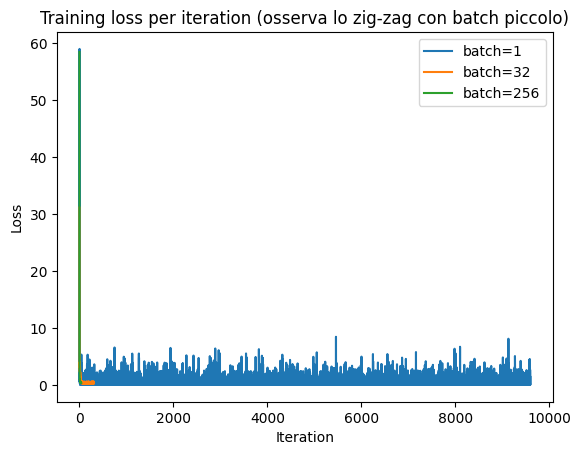

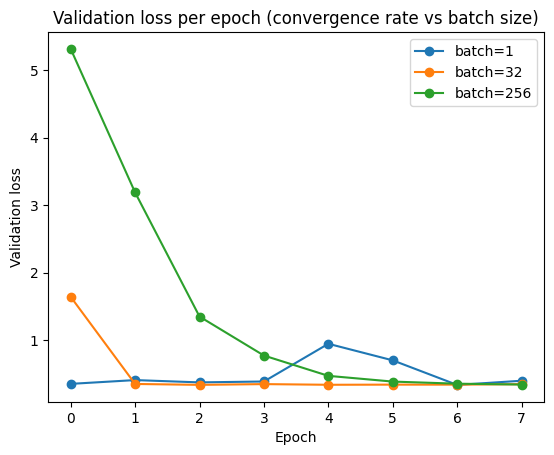


[CHECKPOINT] Modello ripristinato da state_dict():
OrderedDict([('weight', tensor([[2.9781]])), ('bias', tensor([2.2555]))])


In [ ]:
# ========= Mini-Lab: SGD & Mini-Batch in PyTorch =========
# Requirements: pip install torch matplotlib (matplotlib optional for plots)

import math
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# --- 1) Reproducibility
torch.manual_seed(42)
random.seed(42)

# --- 2) Synthetic data: y = 3x + 2 + noise
N_TOTAL = 2000
X = torch.linspace(-5, 5, N_TOTAL).unsqueeze(1)  # shape [N, 1]
noise = torch.randn_like(X) * 0.6
y = 3.0 * X + 2.0 + noise

# Split: train/val/test (60/20/20)
n_train = int(0.6 * N_TOTAL)
n_val   = int(0.2 * N_TOTAL)
x_train, y_train = X[:n_train], y[:n_train]
x_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

# --- 3) Helpers: DataLoader and iteration counting
def make_loader(x, y, batch_size, shuffle=True):
    ds = TensorDataset(x, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def iterations_per_epoch(n_samples, batch_size):
    # Round up when the dataset is not exactly divisible by the batch size
    return math.ceil(n_samples / batch_size)

# --- 4) Linear model
def make_model():
    return nn.Linear(1, 1)  # y_hat = w*x + b (learnable weight and bias)

# --- 5) Generic training loop
def train_one_setting(batch_size=256, lr=0.01, epochs=10, verbose=False):
    model = make_model()
    loss_fn = nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    train_loader = make_loader(x_train, y_train, batch_size=batch_size, shuffle=True)
    val_loader   = make_loader(x_val,   y_val,   batch_size=len(x_val), shuffle=False)

    iter_per_epoch = iterations_per_epoch(len(x_train), batch_size)
    if verbose:
        print(f"[INFO] batch_size={batch_size}, lr={lr}, epochs={epochs}")
        print(f"[INFO] iterations per epoch = {iter_per_epoch}")

    # Track loss per iteration (to see "zig-zag", especially with small batch sizes)
    loss_per_iteration = []
    validation_error_per_epoch = []

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            # 1) zero out old gradients
            opt.zero_grad()
            # 2) forward pass
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)
            # 3) backward pass: compute gradients
            loss.backward()
            # 4) optimizer step: update parameters
            opt.step()

            loss_per_iteration.append(loss.item())

        # Validation and storing as "validation_error" (as in the quiz)
        model.eval()
        with torch.no_grad():
            for xv, yv in val_loader:
                yv_pred = model(xv)
                validation_error = loss_fn(yv_pred, yv).item()
        validation_error_per_epoch.append(validation_error)

        if verbose:
            print(f"Epoch {epoch+1:02d}/{epochs} | val_loss = {validation_error:.4f}")

    # Final test measurement (and keep same naming style)
    test_loader = make_loader(x_test, y_test, batch_size=len(x_test), shuffle=False)
    model.eval()
    with torch.no_grad():
        for xt, yt in test_loader:
            yt_pred = model(xt)
            test_error = loss_fn(yt_pred, yt).item()

    # Expose current parameters via state_dict()
    sd = model.state_dict()  # {'weight': tensor([[w]]), 'bias': tensor([b])}

    results = {
        "model": model,
        "optimizer": opt,
        "loss_per_iteration": loss_per_iteration,
        "validation_error_per_epoch": validation_error_per_epoch,
        "test_error": test_error,
        "state_dict": sd,
        "iterations_per_epoch": iter_per_epoch
    }
    return results

# --- 6) Run three scenarios to compare batch sizes
settings = [
    {"batch_size": 1,   "lr": 0.03, "epochs": 8},   # pure SGD: highest variance per iteration
    {"batch_size": 32,  "lr": 0.05, "epochs": 8},   # typical mini-batch
    {"batch_size": 256, "lr": 0.1,  "epochs": 8},   # large batch, smoother loss
]

all_runs = []
for cfg in settings:
    run = train_one_setting(**cfg, verbose=True)
    all_runs.append((cfg, run))
    print(f"\n[STATE_DICT] batch_size={cfg['batch_size']}, lr={cfg['lr']}")
    for k, v in run["state_dict"].items():
        print(f"  {k}: {v.flatten().tolist()}")  # print w and b as plain numbers

# --- 7) Plots: per-iteration training loss (zig-zag) and per-epoch validation loss
plt.figure()
for cfg, run in all_runs:
    plt.plot(run["loss_per_iteration"], label=f"batch={cfg['batch_size']}")
plt.title("Training loss per iteration (notice zig-zag with small batch)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
for cfg, run in all_runs:
    plt.plot(run["validation_error_per_epoch"], marker="o", label=f"batch={cfg['batch_size']}")
plt.title("Validation loss per epoch (convergence rate vs batch size)")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.legend()
plt.show()

# --- 8) Save/load with state_dict (checkpoint)
best_cfg, best_run = min(all_runs, key=lambda cr: min(cr[1]["validation_error_per_epoch"]))
best_model = best_run["model"]
torch.save(best_model.state_dict(), "best_linear_model.pt")

restored = make_model()
restored.load_state_dict(torch.load("best_linear_model.pt"))
restored.eval()
print("\n[CHECKPOINT] Model restored from state_dict():")
print(restored.state_dict())

